# Final Report Notebook

Here you will find a complete summary of my work for this project--this will include all of the code required to reproduce this project, as well as detailed descriptions and motivations for each step taken.

First we will make the necessary imports:

In [42]:
# General purpose
import pandas as pd
import matplotlib.pyplot as plt
import string

# Visualization formatting
plt.rcParams['font.size'] = 24
plt.style.use('fivethirtyeight')

# Natural language processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import wordnet, stopwords
stops = stopwords.words('english') + ['game', 'player', 'gameplay']
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

# Modeling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Data Acquisition

#### VGChartz

The data in this project came from a few sources. First, we'll start with the scraped data from the video game database [VGChartz](https://www.vgchartz.com/).

The actual scraping work can be found in the exploratory notebook [Initial Web Scraping](../notebooks/01_explore_scrape.ipynb).

Below we will import the resulting data:

In [2]:
df = pd.read_csv('../data/nice_data.csv', low_memory=False)
df.shape

(16719, 16)

We end up with a ton of entries! Let's see how they look

In [3]:
df.sample(3)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
9751,Blackwater,X360,2011.0,Shooter,505 Games,0.09,0.02,0.00,0.01,0.12,37.0,12.0,4.5,14.0,Zombie Studios,T
13848,Monster Band,DS,2008.0,Misc,Tivola,0.04,0.00,0.00,0.00,0.04,NaN,NaN,tbd,NaN,Novarama,E
12105,Lost Heroes 2,3DS,2015.0,Action,Namco Bandai Games,0.00,0.00,0.07,0.00,0.07,NaN,NaN,NaN,NaN,NaN,NaN


Alright, we have a lot of missing data here. We're most interested in the 'critic_score' column, so let's see how many entries are present

In [4]:
scores = df[df.Critic_Score.isna() == False].shape
print(f'{scores[0]} out of {df.shape[0]} possible critic scores are present')

8137 out of 16719 possible critic scores are present


Not too great, a majority of our entries have no critic score values--those will need to be dropped. However, we are still left with over 8,000 games, so we'll take them to the next step

#### Wikipedia

For the next step in acquiring the data, we turn to the Wikipedia API. Using the available python library, getting Wikipedia information is extremely easy. This is good for us, because we will need to make a lot of requests. 

To use the API, you supply the name of the relevant Wikipedia page, and it will return the text of any section you would like. So we send in all of our game titles, along with some variations on them, and we got back most of our entries.

We'll import the resulting data below, but the full work can be found in the [Wikiscraping Notebook](../notebooks/02_wikiscraping.ipynb)

In [5]:
df = pd.read_csv('../data/WEEK_2_DESCRIPTIONS.csv').drop('Unnamed: 0', axis=1)
df.shape

(5499, 17)

Now we have 5,143 entries with full Wikipedia descriptions and critic scores

Let's see one of these descriptions

In [6]:
print(df.plots.sample(random_state=2).values[0])

PokéPark 2: Wonders Beyond features multiplayer capabilities with up to four people. The player uses one of four Pokémon available, Pikachu, Snivy, Tepig, and Oshawott, and can switch them out; each Pokémon has their own special abilities. In chase mode, participants capture or tag the other participant. In battle mode, the player can control their Pokémons every move from dodging, to striking. The player has to win in order to continue with the game. At the end, Pikachu and the others successfully defend the park from all of the evil running havoc on the park.


## Data Understanding

A couple things to note about the game descriptions:
- I'm getting my descriptions directly from Wikipedia, so I don't have to deal with too many errors in the corpus (e.g. spelling, grammar)
- Some of these entries are plot synopses, and some of them are gameplay descriptions. It appears to depend on the type of game.

Now I have all the data I will need, let's take a look at a complete sample entry and examine the columns:

In [7]:
df.sample(random_state=3)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,plots
893,Medal of Honor: Rising Sun,XB,2003.0,Shooter,Electronic Arts,0.76,0.36,0.0,0.05,1.17,65.0,23.0,5.8,28.0,EA LA,T,Medal of Honor: Rising Sun is a first-person s...



**Name**

- The official title of the game at release

**Platform**

- The game system this title was released for: uses the standard abbreviations for each system (e.g. PS3 = Playstation 3, GC = Nintendo GameCube)

**Year of Release**

- The original year the game was released in. This seems to be the earliest year if the release was staggered across regions

**Genre**

- A single genre designation for the game. These are very simple classifications like 'shooter' or 'role-playing'

**Developer**

- The name of the studio responsible for making the game: programming the game, creating the artwork, etc.

**Publisher**

- The name of the company that sells and distributes the game


**NA/EU/JP/Other/Global Sales**

- The number of *units* sold in millions, in each particular region. The global sales figure is the sum of the other four categories

**Critic Score/Critic Count**

- The average of the verified critic scores from Metacritic (these range from 0.0-100.0), as well as the number of reviews that make up that figure. At minimum the score is an average of 3 reviews

**User Score/User Count**

- The average user score on Metacritic (10 point scale), as well as the number of reviews. At minimum there are 4 scores for each game

**Rating**

- The ESRB rating of the game: this can be one of E, E10+, T, M, AO, or K-A

Let's check out the distribution of our critic review scores:

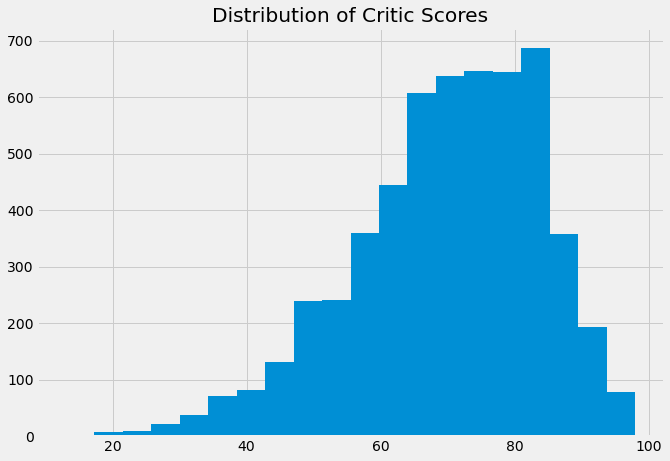

In [8]:
df.Critic_Score.hist(figsize=(10,7), bins=20)
plt.title('Distribution of Critic Scores');

In my experience, this is a typical distribution for ratings: left-skewed with the median around 70%. Let's get our data cleaned up.

## Data Cleaning

#### Binning

The first step I will take is getting the critic scores binned. I would like to make targeting the critic scores a classification rather than a regression problem for the following reason: It's not that meaningful to try to predict what *exact score* a game will recieve. No matter the amount of score averaging, the assigned critic sccore will still have some degree of arbitrariness. More generally I think we care about whether a game receives high, average, or low scores. For this reason I will be grouping the scores in the following three groups:

| Designation | Class | Score Range | 
|:-------------:|:-------:|:-------------:|
|     High    |   2   |  (75,100]  |  
|   Average   |   1   |   (60,75]   |   
|     Low     |   0   |    [0,60]   |   

I will use the following function to do so:

In [9]:
def bin_scores(score):
    if score > 60:
        if score > 75:
            return 2
        return 1
    return 0

df['success'] = df['Critic_Score'].apply(bin_scores)

Let's quickly make sure that we have a decent class balance

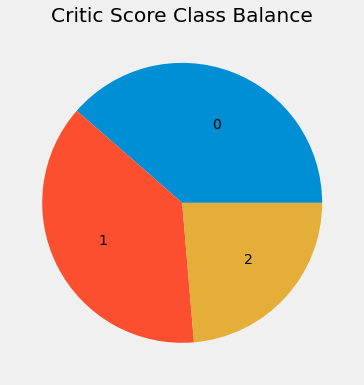

In [10]:
plt.figure(figsize=(6,6))
plt.pie(df.success.value_counts(), labels=[0,1,2], labeldistance=.6)
plt.title('Critic Score Class Balance');

Perfect. The classes have balance, and their designations align with the way people generally think of critical reception

#### Text Processing

Next, I have to take our plots/descriptions and make them a little more usable. This will involve removing punctuation, adjusting case, and maybe removing stopwords.

The text handling libraries I am going to use will do some of this automatically, but it can't hurt to preprocess this way.

In [11]:
def clean_text(text):
    
    # Removes punctuation
    words = [''.join(ch for ch in s if ch not in string.punctuation)\
             for s in text.split()]
    
    # Returns the lower-case string
    return ' '.join(words).lower()

df.plots = df.plots.apply(clean_text)

Here's an example of the cleaned text

In [12]:
print(df.plots.sample(random_state=42).values[0])

in the game dr muto has the ability to morph into many creatures and use a variety of gadgets to get through the game dr muto is able to turn into 5 different creatures with the use of the splizz gun in the game these can be unlocked by collecting items like isotopes and animal dna these morphs also have special extras there are seven different gadgets dr muto can use players get the splizz gun at the start of the game it allows dr muto to extract dna from enemies electrocute and shoot lasers at enemies and allows him to morph into five different creatures


# Modeling

For my first model I will take the game descriptions, vectorize them, and then feed them into a support vector machine to see how they perform

In [13]:
X = df['plots']
y = df['success']
X_train, X_test, y_train, y_test = train_test_split(X, y)

Next I'll make a pipeline so I can cross-validate my models without worrying about data leakage.

In this model I'm using a count vectorizer which turns each document into a vector where each element of the vector is the number of times a specific word appears in that document.

In [14]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('svc', SVC())
])

Let's see how this first model performs

In [15]:
cv = cross_validate(estimator=pipe, X=X_train, y=y_train.values)
print('The average accuracy for this model is {}'.format(cv['test_score'].mean()))

The average accuracy for this model is 0.5550429538099442


Alright, not a bad place to start for a first model, but using a count vectorizer has some issues. First, really long documents become vectors with an enormous magnitude. Also, I would like to pay less attention to words that appear in all game descriptions. Words like 'game', 'player', or 'controller' are very common words and probably don't mean much for this classification.

For these reasons, I will next use a Tfidf vectorizer instead. This will give those common words less value, and it should also factor in the differing document lengths

In [16]:
pipe_2 = Pipeline([
    ('tf', TfidfVectorizer()),
    ('svc', SVC())
])

In [17]:
cv = cross_validate(estimator=pipe_2, X=X_train, y=y_train.values)
print('The average accuracy for this model is {}'.format(cv['test_score'].mean()))

The average accuracy for this model is 0.6418505442777288


Great! Just by using a more sophisticated vectorizer, I am getting about 15% fewer errors

Next 

In [18]:
pipe_2 = Pipeline([
    ('tf', TfidfVectorizer()),
    ('svc', NuSVC())
])

In [19]:
cv = cross_validate(estimator=pipe_2, X=X_train, y=y_train.values)
print('The average accuracy for this model is {}'.format(cv['test_score'].mean()))

The average accuracy for this model is 0.645243601059135


In [20]:
params = {
    'tf__max_features': (500,1000),
    'svc__nu': (.25, .5),
    'svc__kernel': ('rbf', 'poly')    
}

In [21]:
gs = GridSearchCV(pipe_2, params, verbose=2, return_train_score=True)

In [22]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] svc__kernel=rbf, svc__nu=0.25, tf__max_features=500 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  svc__kernel=rbf, svc__nu=0.25, tf__max_features=500, total=  12.7s
[CV] svc__kernel=rbf, svc__nu=0.25, tf__max_features=500 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s remaining:    0.0s


[CV]  svc__kernel=rbf, svc__nu=0.25, tf__max_features=500, total=  12.9s
[CV] svc__kernel=rbf, svc__nu=0.25, tf__max_features=500 .............
[CV]  svc__kernel=rbf, svc__nu=0.25, tf__max_features=500, total=  12.5s
[CV] svc__kernel=rbf, svc__nu=0.25, tf__max_features=500 .............
[CV]  svc__kernel=rbf, svc__nu=0.25, tf__max_features=500, total=  12.5s
[CV] svc__kernel=rbf, svc__nu=0.25, tf__max_features=500 .............
[CV]  svc__kernel=rbf, svc__nu=0.25, tf__max_features=500, total=  11.8s
[CV] svc__kernel=rbf, svc__nu=0.25, tf__max_features=1000 ............
[CV]  svc__kernel=rbf, svc__nu=0.25, tf__max_features=1000, total=  14.3s
[CV] svc__kernel=rbf, svc__nu=0.25, tf__max_features=1000 ............
[CV]  svc__kernel=rbf, svc__nu=0.25, tf__max_features=1000, total=  13.9s
[CV] svc__kernel=rbf, svc__nu=0.25, tf__max_features=1000 ............
[CV]  svc__kernel=rbf, svc__nu=0.25, tf__max_features=1000, total=  14.0s
[CV] svc__kernel=rbf, svc__nu=0.25, tf__max_features=1000 ..

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 15.1min finished


GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('svc', NuSVC())]),
             param_grid={'svc__kernel': ('rbf', 'poly'), 'svc__nu': (0.25, 0.5),
                         'tf__max_features': (500, 1000)},
             return_train_score=True, verbose=2)

In [23]:
gs.best_score_

0.6433065607531626

Didn't get too much better on that one, let me try another route that I had previous success with.

In [35]:
tf = TfidfVectorizer(stop_words='english')
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tf)

In [36]:
accuracy_score(y_test, y_predicted_tfidf)

0.0

Here I would like to explore more, in my previous exploration I had better results with logistic regression

# Evaluation

My model attained an accuracy score of 64%. This means that 64% of the time, when given a Wikipedia-grade description of a game, it can correctly predict the critical reception of that game--within these three predefined classes. Obvously this score is not ideal and it will require more tuning and perhaps more data collection. I think what I will do next is re-tune my Wikipedia API script to prioritize the 'gameplay' section of the page rather than the 'plot' section.